# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow.compat.v1 as tf

In [21]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [2]:
data_covid = pd.read_csv('covid_19_clean_complete.csv')

Convertimos a dataframe de Pandas y obtenemos solo las columnas de País, Fecha y Confirmados

In [3]:
data_covid = pd.DataFrame(data = data_covid, columns = ["Country/Region", "Date", "Confirmed"])
data_covid.head()

,Country/Region,Date,Confirmed
0,Afghanistan,1/22/20,0
1,Albania,1/22/20,0
2,Algeria,1/22/20,0
3,Andorra,1/22/20,0
4,Angola,1/22/20,0


#### Limpiza de datos
Filtramos solo por Guatemala y aprovechamos a quitar la columna de País. 

Se hará caso omiso a los días que no se hayan reportado casos. Esto quiere decir que el dia 0 no sera el 22/01/2020, sino el 14/03/2020

In [4]:
data_covid = data_covid[data_covid["Country/Region"] == "Guatemala"]
data_covid = data_covid[data_covid["Confirmed"] > 0]

data_covid = data_covid.drop("Country/Region", axis = 1)
data_covid.head()

,Date,Confirmed
13851,3/14/20,1
14115,3/15/20,1
14379,3/16/20,2
14643,3/17/20,6
14907,3/18/20,6


Creamos la transformación de la columna de Fecha a números enteros. Para volver el 14 de marzo el día 0 e irle sumando 1 al cada uno de los días que le siguen.

In [5]:
data_covid["Day"] = data_covid["Date"].apply(lambda x: 
                                    (dt.datetime.strptime(x,'%m/%d/%y').date() - dt.datetime.strptime("3/14/20", '%m/%d/%y').date()).days)
data_covid.head()

,Date,Confirmed,Day
13851,3/14/20,1,0
14115,3/15/20,1,1
14379,3/16/20,2,2
14643,3/17/20,6,3
14907,3/18/20,6,4


Ahora creamos una columna para los casos confirmados por día. Actualmente tenemos el acumulado, pero necesitamos los casos que se dieron por día.

In [6]:
data_covid["Cases"] = np.zeros(data_covid["Day"].shape, dtype=int)
data_covid.head()

,Date,Confirmed,Day,Cases
13851,3/14/20,1,0,0
14115,3/15/20,1,1,0
14379,3/16/20,2,2,0
14643,3/17/20,6,3,0
14907,3/18/20,6,4,0


In [16]:
data_covid.iloc[0, 3] = data_covid.iloc[0, 1]
for i in range(1, len(data_covid["Cases"])):
    data_covid.iloc[i, 3] = data_covid.iloc[i, 1] - data_covid.iloc[i-1, 1]
data_covid.head()

,Date,Confirmed,Day,Cases
13851,3/14/20,1,0,1
14115,3/15/20,1,1,0
14379,3/16/20,2,2,1
14643,3/17/20,6,3,4
14907,3/18/20,6,4,0


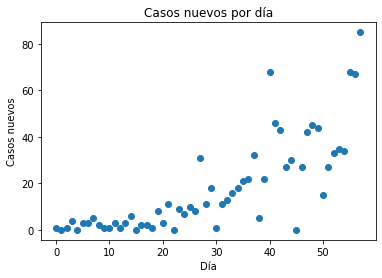

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data_covid["Day"], data_covid["Cases"])
ax.set_xlabel("Día")
ax.set_ylabel("Casos nuevos")
ax.set_title("Casos nuevos por día")
ax.set_aspect('auto')
    
plt.show()

#### Entrenamiento del modelo
Procedemos a crear una clase que nos devuelva los parámetros $\theta$ luego de un entrenamiento.

In [22]:
class LinearRegression:
    #Inicializador de thetas a 0
    def __init__(self, n): 
        self.theta = tf.get_variable("theta", dtype=tf.float32, shape=[1, n], initializer=tf.zeros_initializer())

    def __call__(self, x):
        return tf.matmul(self.theta, x)
    
    #Función a optimizar por tf.gradients
    def mse(self, x, y):
        mse = 0.5 * tf.reduce_mean(tf.math.square(y - self(x)))
        return mse
    
    #Actualización de thetas
    def update(self, x, y, learning_rate):
        with tf.name_scope("cost_function"):
            mse = self.mse(x, y)
            mse_summary = tf.summary.scalar("mse_summary", mse)
        gradients = tf.gradients(mse, [self.theta])
        theta_new = tf.assign(self.theta, self.theta - learning_rate * gradients[0])
        return theta_new, mse, mse_summary

In [37]:
def LinearTraining(x, y, epochs, imprimir_error_cada, learning_rate):
    #log_name = './logs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_lr=' + str(learning_rate)+ '_epochs=' + str(epochs)
    n, m = x.shape
    salida = np.array((1, n))
    g = tf.Graph()
    with g.as_default():
        model = LinearRegression(n)
        tensor_x = tf.placeholder(tf.float32, [n, m], "tensor_x")
        tensor_y = tf.placeholder(tf.float32, [m], "tensor_y")
        
        update_parameters = model.update(tensor_x, tensor_y, learning_rate)
        
        #writer = tf.summary.FileWriter(log_name, g)
        
        with tf.train.MonitoredSession() as session:
            parameters_dict = {tensor_x:x, tensor_y:y}
            for i in range(epochs + 1):
                training = session.run(update_parameters, feed_dict = parameters_dict)
                salida = training[0]
            
                if (i % imprimir_error_cada) == 0:
                    W = session.run(model.theta, feed_dict = parameters_dict)
                    #writer.add_summary(training[2], i)
                    print("Epoch ", i, ": Thetas: ", W, "Cost: ", training[1])
                    
    return(salida)

In [24]:
y = data_covid["Cases"]
x = data_covid["Day"]
x = np.array([x, np.ones_like(x)], dtype = "float32")

In [38]:
theta = LinearTraining(x, y, 15000, 500, 0.00125)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[0.97616374 0.02267241]] Cost:  368.86206
Epoch  500 : Thetas:  [[ 0.7480541 -1.2760627]] Cost:  87.115456
Epoch  1000 : Thetas:  [[ 0.77677274 -2.3766851 ]] Cost:  85.17087
Epoch  1500 : Thetas:  [[ 0.80123913 -3.3143444 ]] Cost:  83.7595
Epoch  2000 : Thetas:  [[ 0.8220833 -4.1131825]] Cost:  82.7351
Epoch  2500 : Thetas:  [[ 0.8398409 -4.79373  ]] Cost:  81.99163
Epoch  3000 : Thetas:  [[ 0.8549692 -5.373513 ]] Cost:  81.452
Epoch  3500 : Thetas:  [[ 0.86785764 -5.8674536 ]] Cost:  81.060356
Epoch  4000 : Thetas:  [[ 0.87883776 -6.288259  ]] Cost:  80.77609
Epoch  4500 : Thetas:  [[ 0.8881921 -6.646759 ]] Cost:  80.56978
Epoch  5000 : Thetas:  [[ 0.8961614 -6.9521766]] Cost:  80.42004
Epoch  5500 : Thetas:  [[ 0.9029509 -7.2123804]] Cost:  80.311356
Epoch  6000 : Thetas:  [[ 0.908735  -7.4340525]] Cost:  80.232475
Epoch  6500 : Thetas:  [[ 0.91

In [53]:
print("Pesos determinados: ", theta)

Pesos determinados:  [[ 0.94015574 -8.638231  ]]


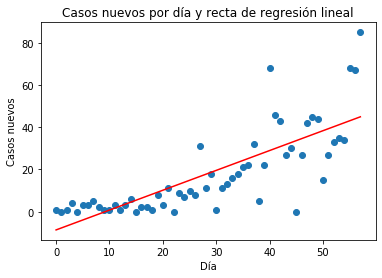

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data_covid["Day"], data_covid["Cases"])
ax.plot(data_covid["Day"], data_covid["Day"]*theta[0, 0] + theta[0, 1], 'r')
ax.set_xlabel("Día")
ax.set_ylabel("Casos nuevos")
ax.set_title("Casos nuevos por día y recta de regresión lineal")
ax.set_aspect('auto')
    
plt.show()

#### Predición
Ya que tenemos los parámetros, los utilizamos para predecir los casos del día 83, ya que ese sería el correspondiente para el 30 de mayo.

Primero, insertamos las suficientes filas para llegar al día 83. Luego, creamos una nueva columna con los casos predichos por el modelo. Acá se hace una corrección porque no puede haber una cantidad negativa de casos, por lo que cualquier número negativo se volverá a 0.

In [75]:
for i in range(58, 84):
    data_covid = data_covid.append({'Date': '--', 'Confirmed': 0, 'Day': i, 'Cases': 0}, ignore_index=True)

In [85]:
data_covid["Predicted"] = np.zeros(data_covid["Day"].shape, dtype=int)
for i in range(1, len(data_covid["Day"])):
    nuevos_casos = int(data_covid.iloc[i, 2] * theta[0, 0] + theta[0, 1])
    if(nuevos_casos < 0):
        nuevos_casos = 0
    data_covid.iloc[i, 3] = nuevos_casos
    data_covid.iloc[i, 4] = data_covid.iloc[i-1, 4] + nuevos_casos

In [86]:
data_covid

,Date,Confirmed,Day,Cases,Predicted
0,3/14/20,1,0,1,0
1,3/15/20,1,1,0,0
2,3/16/20,2,2,0,0
3,3/17/20,6,3,0,0
4,3/18/20,6,4,0,0
...,...,...,...,...,...
79,--,0,79,65,2288
80,--,0,80,66,2354
81,--,0,81,67,2421
82,--,0,82,68,2489


#### Respuesta
Según el modelo obtenido, el 30 de mayo debería haber un **total de 2558 casos activos**. 
> La información oficial para ese día fue de 3929 casos activos. El modelo está muy lejos del dato real.



### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
